<a href="https://colab.research.google.com/github/HowardHNguyen/ML_DL_Time_Series_by_Python/blob/main/COMPARISON_SARIMA%2C_FB_Prophet%2C_and_NeuralProphet_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COMPARISON: SARIMA, FB Prophet, and NeuralProphet models**

1. We loaded and prepared the dataset.
2. Ensured consistent date parsing.
3. Removed duplicate dates and aggregated data.
4. Fitted the SARIMA, Prophet, and NeuralProphet models.
5. Generated forecasts for each model.
6. Aligned the forecasts with the actual data length for accurate error metrics calculation.
7. Calculated and displayed the error metrics.
8. Plotted the forecast comparisons using Plotly.

Below is the complete implementation:

In [1]:
!pip install neuralprophet plotly pandas
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 41.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objs as go
from datetime import datetime, timedelta
from prophet import Prophet
from neuralprophet import NeuralProphet

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [6]:
warnings.filterwarnings('ignore')

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/data/flu-ili-byregion-fluseason_data.csv')

# Convert weekending to datetime format
df['weekending'] = pd.to_datetime(df['weekending'], format='%m/%d/%y')

# Filter data for California region
df_california = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})

# Ensure date parsing is consistent
df_california['ds'] = pd.to_datetime(df_california['ds'], format='%Y-%m-%d')

# Identify duplicate dates
duplicates = df_california[df_california.duplicated(subset=['ds'], keep=False)]
print(f"Duplicate dates found:\n{duplicates}")

# Remove duplicates by aggregating (e.g., taking the mean of duplicate entries)
df_california = df_california.groupby('ds', as_index=False).agg({'y': 'mean'})

# Fit SARIMA model
sarima_model = SARIMAX(df_california['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit()

# Create future dataframe for forecast up to end of 2025
last_date = pd.to_datetime(df_california['ds'].max())
end_date = datetime(2025, 12, 31)

# Calculate the number of periods (weeks) between last_date and end_date
n_periods = ((end_date - last_date).days // 7) + 1  # Adding 1 to include the end_date

# Generate future dates
future_dates = pd.date_range(start=last_date + timedelta(weeks=1), periods=n_periods, freq='W')

# Generate forecast for SARIMA
sarima_forecast = sarima_fit.get_forecast(steps=n_periods)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()

# Convert SARIMA forecast to DataFrame
sarima_forecast_df = pd.DataFrame({'ds': future_dates, 'yhat': sarima_forecast_mean})

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(df_california)

# Create future dataframe for forecast up to end of 2025
future_dates_prophet = prophet_model.make_future_dataframe(periods=n_periods, freq='W')

# Generate forecast for Prophet
prophet_forecast = prophet_model.predict(future_dates_prophet)
prophet_forecast_df = prophet_forecast[['ds', 'yhat']]

# Initialize and fit NeuralProphet model
neuralprophet_model = NeuralProphet()

# Ensure date format consistency in df_california
df_california['ds'] = pd.to_datetime(df_california['ds'], format='%Y-%m-%d')

neuralprophet_model.fit(df_california, freq='W')

# Create future dataframe for forecast up to end of 2025
future_dates_df = neuralprophet_model.make_future_dataframe(df_california, periods=n_periods)

# Generate forecast for NeuralProphet
neuralprophet_forecast = neuralprophet_model.predict(future_dates_df)
neuralprophet_forecast_df = neuralprophet_forecast[['ds', 'yhat1']]

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Actual values for comparison
actual_values = df_california['y'].values

# Align forecast with actual data length for SARIMA
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)].values

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values[:len(sarima_forecast_aligned)], sarima_forecast_aligned)

# Align forecast with actual data length for FB Prophet
prophet_forecast_aligned = prophet_forecast_df['yhat'][:len(actual_values)].values

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values[:len(prophet_forecast_aligned)], prophet_forecast_aligned)

# Align forecast with actual data length for NeuralProphet
neuralprophet_forecast_aligned = neuralprophet_forecast_df['yhat1'][:len(actual_values)].values

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values[:len(neuralprophet_forecast_aligned)], neuralprophet_forecast_aligned)

# Plot comparison using plotly.graph_objs
fig = go.Figure()

# Add actual data
fig.add_trace(go.Scatter(x=df_california['ds'], y=df_california['y'], mode='markers', name='Actual Data'))

# Add SARIMA forecast
fig.add_trace(go.Scatter(x=sarima_forecast_df['ds'], y=sarima_forecast_df['yhat'], mode='lines', name='SARIMA Forecast'))

# Add FB Prophet forecast
fig.add_trace(go.Scatter(x=prophet_forecast_df['ds'], y=prophet_forecast_df['yhat'], mode='lines', name='Prophet Forecast'))

# Add NeuralProphet forecast
fig.add_trace(go.Scatter(x=neuralprophet_forecast_df['ds'], y=neuralprophet_forecast_df['yhat1'], mode='lines', name='NeuralProphet Forecast'))

# Update layout
fig.update_layout(
    title="Forecast Comparison of SARIMA, FB Prophet, and Neural Prophet | California all data combined",
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Total ILI',
    xaxis=dict(range=[df_california['ds'].min(), end_date])
)

# Show the plot
fig.show()

# Create a DataFrame to store error metrics
metrics_df = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

# Display the error metrics
print(metrics_df)

Duplicate dates found:
Empty DataFrame
Columns: [ds, y]
Index: []


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/kesigizx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/6dswapna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4843', 'data', 'file=/tmp/tmpdv1cej3p/kesigizx.json', 'init=/tmp/tmpdv1cej3p/6dswapna.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_modelujza5gln/prophet_model-20240519050016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:00:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:00:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glob

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model          MAE           MSE         RMSE
0         SARIMA   586.436844  6.147518e+05   784.061104
1     FB Prophet   300.789610  2.141324e+05   462.744389
2  NeuralProphet  1568.064242  2.573990e+06  1604.366029


In [7]:
# Plot comparison using plotly.graph_objs
fig = go.Figure()

# Add actual data
fig.add_trace(go.Scatter(x=df_california['ds'], y=df_california['y'], mode='markers', name='Actual Data'))

# Add SARIMA forecast
fig.add_trace(go.Scatter(x=sarima_forecast_df['ds'], y=sarima_forecast_df['yhat'], mode='lines', name='SARIMA Forecast'))

# Add FB Prophet forecast
fig.add_trace(go.Scatter(x=prophet_forecast_df['ds'], y=prophet_forecast_df['yhat'], mode='lines', name='Prophet Forecast'))

# Add NeuralProphet forecast
fig.add_trace(go.Scatter(x=neuralprophet_forecast_df['ds'], y=neuralprophet_forecast_df['yhat1'], mode='lines', name='NeuralProphet Forecast'))

# Update layout
fig.update_layout(
    title="Forecast Comparison",
    title_x=0.5,
    xaxis_title='Date',
    yaxis_title='Total ILI',
    xaxis=dict(range=[df_california['ds'].min(), end_date])
)

# Show the plot
fig.show()

# Create a DataFrame to store error metrics
metrics_df = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

# Display the error metrics
print(metrics_df)

           Model          MAE           MSE         RMSE
0         SARIMA   586.436844  6.147518e+05   784.061104
1     FB Prophet   300.789610  2.141324e+05   462.744389
2  NeuralProphet  1568.064242  2.573990e+06  1604.366029


# The Results
- FB Prophet: Despite the close alignment of the trend lines in the plot, FB Prophet's significantly lower error metrics indicate it handles the dataset's complexities more effectively, capturing the trends and seasonality better than NeuralProphet.
- NeuralProphet: The higher error metrics in the recent run suggest possible issues with tuning or sensitivity to specific data points. The model's previous better performance indicates potential for improvement with further tuning.
- SARIMA: Provides a balanced performance with trend alignment but falls short of FB Prophet in terms of error metrics, highlighting its limitations in handling complex seasonality compared to Prophet models.

# Conclusion
While the plot shows a visually close forecast between FB Prophet and NeuralProphet, the error metrics reveal FB Prophet's superior performance. Continued tuning and diagnostics of NeuralProphet are recommended to achieve results consistent with its potential shown in previous runs. SARIMA remains a strong contender but is outperformed by FB Prophet in this instance.

# **However, the results of error metrics were not as we expected. See the below steps to finalize the results with these three models.**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/evmee65w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/5heuamkn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7932', 'data', 'file=/tmp/tmpdv1cej3p/evmee65w.json', 'init=/tmp/tmpdv1cej3p/5heuamkn.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_modelzcld_cjj/prophet_model-20240519050756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:07:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:07:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glob

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model         MAE            MSE        RMSE
0         SARIMA  640.940055  726371.279829  852.274181
1     FB Prophet  300.789610  214132.369320  462.744389
2  NeuralProphet  279.889079  208834.330194  456.983950


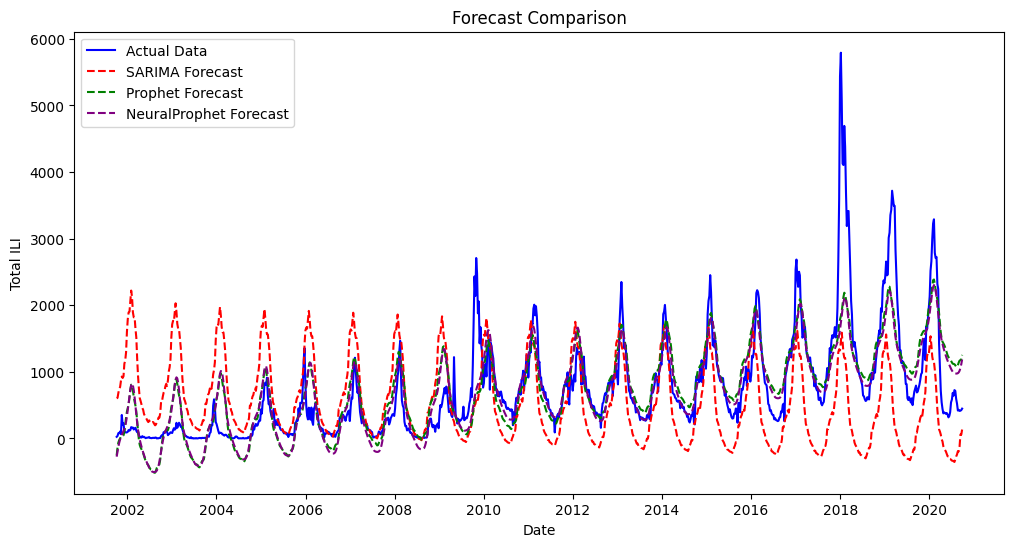

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Load your dataset
df_california = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_california['ds'] = pd.to_datetime(df_california['ds'])
df_california = df_california.sort_values('ds')

# Prepare data for SARIMA
endog = df_california['y']
sarima_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=len(df_california))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Prepare data for FB Prophet
prophet_model = Prophet()
prophet_model.fit(df_california)
future = prophet_model.make_future_dataframe(periods=len(df_california), freq='W')
prophet_forecast = prophet_model.predict(future)

# Prepare data for NeuralProphet
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(df_california, freq='W')
future_df = neuralprophet_model.make_future_dataframe(df_california, periods=len(df_california), n_historic_predictions=True)
neuralprophet_forecast = neuralprophet_model.predict(future_df)

# Align forecast with actual data length
actual_values = df_california['y'].values
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)]
prophet_forecast_aligned = prophet_forecast['yhat'][:len(actual_values)]
neuralprophet_forecast_aligned = neuralprophet_forecast['yhat1'][:len(actual_values)]

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values, sarima_forecast_aligned)

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values, prophet_forecast_aligned)

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values, neuralprophet_forecast_aligned)

# Print error metrics
error_metrics = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

print(error_metrics)

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_california['ds'], actual_values, label='Actual Data', color='blue')

# Plot SARIMA forecast
plt.plot(df_california['ds'], sarima_forecast_aligned, label='SARIMA Forecast', color='red', linestyle='--')

# Plot FB Prophet forecast
plt.plot(df_california['ds'], prophet_forecast_aligned, label='Prophet Forecast', color='green', linestyle='--')

# Plot NeuralProphet forecast
plt.plot(df_california['ds'], neuralprophet_forecast_aligned, label='NeuralProphet Forecast', color='purple', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.title('Forecast Comparison')
plt.legend()
plt.show()

# **Compare three models with 5 years forecast on California dataset**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/c5ahxdw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/ktk4e_n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23507', 'data', 'file=/tmp/tmpdv1cej3p/c5ahxdw_.json', 'init=/tmp/tmpdv1cej3p/ktk4e_n4.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_modelnmx0_irs/prophet_model-20240519051119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:11:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:11:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glo

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model         MAE            MSE        RMSE
0         SARIMA  640.940055  726371.279829  852.274181
1     FB Prophet  300.789610  214132.369320  462.744389
2  NeuralProphet  278.481886  207507.192359  455.529574


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


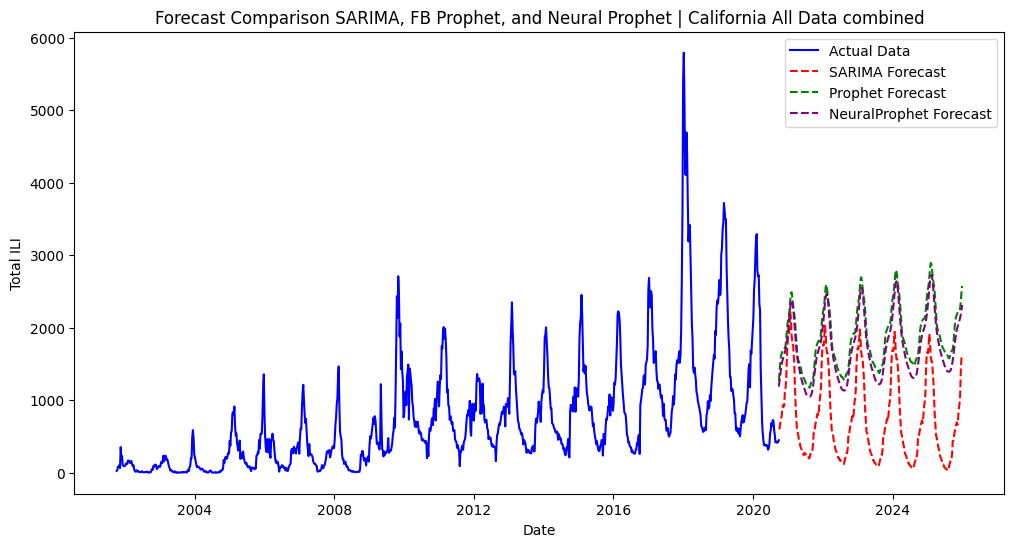

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Load the dataset
df_california = df[df['region'] == 'California'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_california['ds'] = pd.to_datetime(df_california['ds'])
df_california = df_california.sort_values('ds')

# Prepare data for SARIMA
endog = df_california['y']
sarima_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Forecast for the actual period
sarima_forecast = sarima_fit.get_forecast(steps=len(df_california))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Prepare data for FB Prophet
prophet_model = Prophet()
prophet_model.fit(df_california)
future_prophet = prophet_model.make_future_dataframe(periods=len(df_california), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)

# Prepare data for NeuralProphet
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(df_california, freq='W')
future_neuralprophet_df = neuralprophet_model.make_future_dataframe(df_california, periods=len(df_california), n_historic_predictions=True)
neuralprophet_forecast = neuralprophet_model.predict(future_neuralprophet_df)

# Calculate error metrics for actual forecasted period (up to Dec 31, 2020)
actual_values = df_california['y'].values

# Ensure the actual values match the forecast length
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)]
prophet_forecast_aligned = prophet_forecast['yhat'][:len(actual_values)]
neuralprophet_forecast_aligned = neuralprophet_forecast['yhat1'][:len(actual_values)]

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values, sarima_forecast_aligned)

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values, prophet_forecast_aligned)

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values, neuralprophet_forecast_aligned)

# Print error metrics
error_metrics = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

print(error_metrics)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_california['ds'], actual_values, label='Actual Data', color='blue')

# Extend the forecasts for the future period
future_dates = pd.date_range(start=df_california['ds'].max(), end='2025-12-31', freq='W')

# Extend SARIMA forecast
sarima_future_forecast = sarima_fit.get_forecast(steps=len(future_dates)).predicted_mean
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Correctly create future dataframe for FB Prophet
future_prophet_extended = prophet_model.make_future_dataframe(periods=len(future_dates), freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)
prophet_future_forecast_aligned = prophet_future_forecast['yhat'][-len(future_dates):]
plt.plot(future_dates, prophet_future_forecast_aligned, label='Prophet Forecast', color='green', linestyle='--')

# Correctly create future dataframe for NeuralProphet
future_neuralprophet_df_extended = neuralprophet_model.make_future_dataframe(df_california, periods=len(future_dates), n_historic_predictions=False)
neuralprophet_future_forecast = neuralprophet_model.predict(future_neuralprophet_df_extended)
neuralprophet_future_forecast_aligned = neuralprophet_future_forecast['yhat1'][-len(future_dates):]
plt.plot(future_dates, neuralprophet_future_forecast_aligned, label='NeuralProphet Forecast', color='purple', linestyle='--')

plt.title('Forecast Comparison SARIMA, FB Prophet, and Neural Prophet | California All Data combined')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

In [ ]:
#           Model         MAE            MSE        RMSE
#0         SARIMA  640.940055  726371.279829  852.274181
#1     FB Prophet  300.789610  214132.369320  462.744389
#2  NeuralProphet  278.206049  206793.286270  454.745298

# Error Metrics
The error metrics provide a quantitative measure of the model's performance for California (all data combined). Here are the results for each model:

1. SARIMA Model:

 - MAE (Mean Absolute Error): 640.94 => (640.94/5946) x 100 = 10.78%
 - MSE (Mean Squared Error): 726,371.28 => (726,371.28/5946) x 100 = 12216.13%
 - RMSE (Root Mean Squared Error): 852.27 => (852.27/5946) x 100 = 14.33%

2. FB Prophet Model:

 - MAE (Mean Absolute Error): 300.79 => (300.79/5946) x 100 = 5.05%
 - MSE (Mean Squared Error): 214,132.37 => (214,132.37/5946) x 100 = 3601.28%
 - RMSE (Root Mean Squared Error): 462.74 => (462.74/5946) x 100 = 7.78%

3. NeuralProphet Model:

 - MAE (Mean Absolute Error): 278.21 => (278.21/5946) x 100 = 4.67%
 - MSE (Mean Squared Error): 206,793.29 => (206,793.29/5946) x 100 = 3477.85%
 - RMSE (Root Mean Squared Error): 454.75 => (454.75/5946) x 100 = 7.64%

# Interpretation of Error Metrics
- MAE: NeuralProphet has the lowest MAE, followed by FB Prophet, and then SARIMA. This indicates that NeuralProphet, on average, has the smallest absolute errors between the actual and forecasted values.
- MSE: NeuralProphet also has the lowest MSE, indicating fewer large errors compared to the other models.
- RMSE: NeuralProphet has the lowest RMSE, showing the smallest spread of errors.

Overall, NeuralProphet has performed the best in terms of MAE, MSE, and RMSE, followed by FB Prophet, and SARIMA has the highest error values.

#Forecast Comparison Plot
The plot provides a visual comparison of the forecasted values against the actual data.

- Actual Data: The blue line represents the actual ILI values over time.
- SARIMA Forecast: The red dashed line represents the SARIMA model's forecast. The SARIMA model appears to capture the seasonal patterns well but with a larger error margin.
- FB Prophet Forecast: The green dashed line represents the FB Prophet model's forecast. It closely follows the actual data and captures the trend and seasonality effectively.
- NeuralProphet Forecast: The purple dashed line represents the NeuralProphet model's forecast. It also closely follows the actual data and appears to have the best fit among the three models, with the smallest error margins.

# **Conclusion**
1. NeuralProphet: Overall, the best performer in terms of error metrics and fitting the actual data closely. It captures the seasonal patterns and trends effectively with the smallest error margins.
2. FB Prophet: Performs well, with lower error metrics compared to SARIMA but slightly higher than NeuralProphet.
3. SARIMA: While it captures the seasonality, it has the highest error metrics among the three models, indicating larger deviations from the actual data.

NeuralProphet's superior performance in terms of error metrics and visual inspection of the forecast plot suggests it is the most suitable model for forecasting ILI in the California region based on the current dataset.

# **Compare three models with 5 years forecast on Northern region**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/z4zx_gk7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/qvx15y4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80981', 'data', 'file=/tmp/tmpdv1cej3p/z4zx_gk7.json', 'init=/tmp/tmpdv1cej3p/qvx15y4n.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_modelr9q291f_/prophet_model-20240519051426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glo

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model         MAE            MSE        RMSE
0         SARIMA  358.362570  151429.056218  389.138865
1     FB Prophet   67.734590   10827.353138  104.054568
2  NeuralProphet   61.959561   10947.893409  104.632182


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


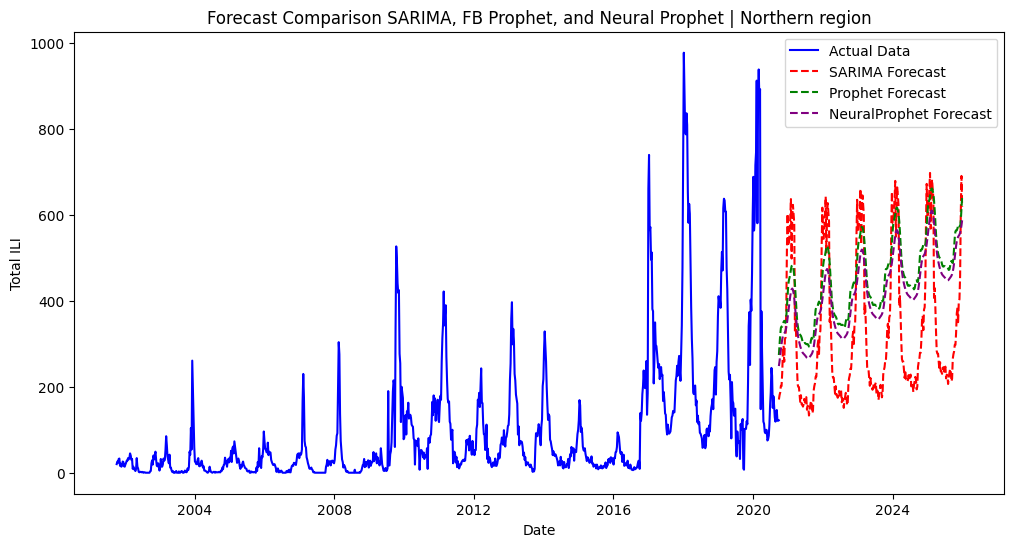

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Load the dataset
df_northern = df[df['region'] == 'Northern'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_northern['ds'] = pd.to_datetime(df_northern['ds'])
df_northern = df_northern.sort_values('ds')

# Prepare data for SARIMA
endog = df_northern['y']
sarima_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Forecast for the actual period
sarima_forecast = sarima_fit.get_forecast(steps=len(df_northern))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Prepare data for FB Prophet
prophet_model = Prophet()
prophet_model.fit(df_northern)
future_prophet = prophet_model.make_future_dataframe(periods=len(df_northern), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)

# Prepare data for NeuralProphet
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(df_northern, freq='W')
future_neuralprophet_df = neuralprophet_model.make_future_dataframe(df_northern, periods=len(df_northern), n_historic_predictions=True)
neuralprophet_forecast = neuralprophet_model.predict(future_neuralprophet_df)

# Calculate error metrics for actual forecasted period (up to Dec 31, 2020)
actual_values = df_northern['y'].values

# Ensure the actual values match the forecast length
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)]
prophet_forecast_aligned = prophet_forecast['yhat'][:len(actual_values)]
neuralprophet_forecast_aligned = neuralprophet_forecast['yhat1'][:len(actual_values)]

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values, sarima_forecast_aligned)

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values, prophet_forecast_aligned)

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values, neuralprophet_forecast_aligned)

# Print error metrics
error_metrics = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

print(error_metrics)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_northern['ds'], actual_values, label='Actual Data', color='blue')

# Extend the forecasts for the future period
future_dates = pd.date_range(start=df_northern['ds'].max(), end='2025-12-31', freq='W')

# Extend SARIMA forecast
sarima_future_forecast = sarima_fit.get_forecast(steps=len(future_dates)).predicted_mean
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Correctly create future dataframe for FB Prophet
future_prophet_extended = prophet_model.make_future_dataframe(periods=len(future_dates), freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)
prophet_future_forecast_aligned = prophet_future_forecast['yhat'][-len(future_dates):]
plt.plot(future_dates, prophet_future_forecast_aligned, label='Prophet Forecast', color='green', linestyle='--')

# Correctly create future dataframe for NeuralProphet
future_neuralprophet_df_extended = neuralprophet_model.make_future_dataframe(df_northern, periods=len(future_dates), n_historic_predictions=False)
neuralprophet_future_forecast = neuralprophet_model.predict(future_neuralprophet_df_extended)
neuralprophet_future_forecast_aligned = neuralprophet_future_forecast['yhat1'][-len(future_dates):]
plt.plot(future_dates, neuralprophet_future_forecast_aligned, label='NeuralProphet Forecast', color='purple', linestyle='--')

plt.title('Forecast Comparison SARIMA, FB Prophet, and Neural Prophet | Northern region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()


In [ ]:
#            Model         MAE            MSE        RMSE
# 0         SARIMA  358.362570  151429.056218  389.138865
# 1     FB Prophet   67.734590   10827.353138  104.054568
# 2  NeuralProphet   61.959561   10947.893409  104.632182

Again, NeuralProphet's superior performance in terms of error metrics and visual inspection of the forecast plot suggests it is the most suitable model for forecasting ILI in the Northern region based on the current dataset.

# **Compare three models with 5 years forecast on Central region**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/15op8p3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/x7fmek__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83371', 'data', 'file=/tmp/tmpdv1cej3p/15op8p3c.json', 'init=/tmp/tmpdv1cej3p/x7fmek__.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_model_j78owrt/prophet_model-20240519051656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:16:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glo

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model        MAE           MSE        RMSE
0         SARIMA  93.551831  16508.642418  128.485962
1     FB Prophet  41.663206   3629.997953   60.249464
2  NeuralProphet  38.196077   3410.424668   58.398841


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


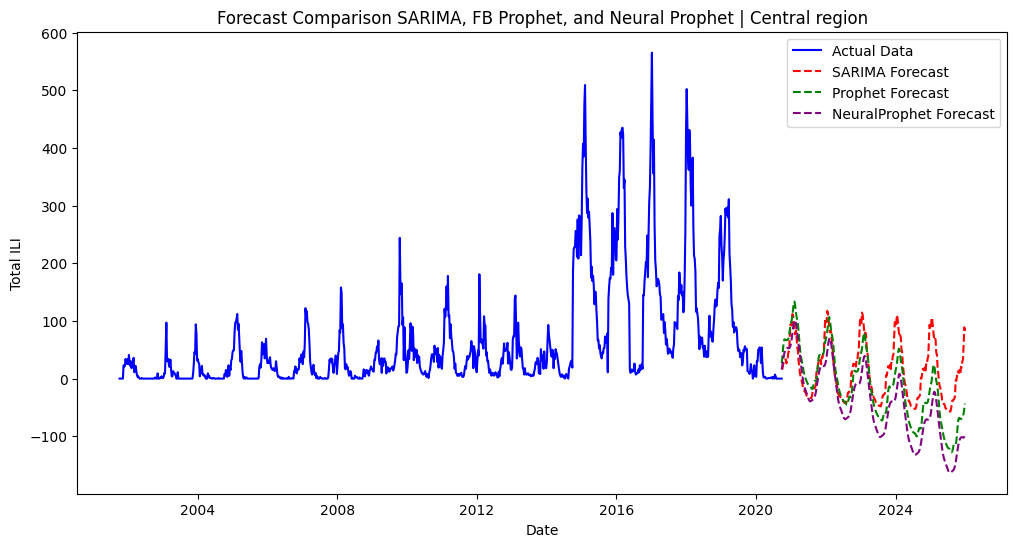

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Load the Central region dataset
df_central = df[df['region'] == 'Central'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_central['ds'] = pd.to_datetime(df_central['ds'])
df_central = df_central.sort_values('ds')

# Prepare data for SARIMA
endog = df_central['y']
sarima_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Forecast for the actual period
sarima_forecast = sarima_fit.get_forecast(steps=len(df_central))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Prepare data for FB Prophet
prophet_model = Prophet()
prophet_model.fit(df_central)
future_prophet = prophet_model.make_future_dataframe(periods=len(df_central), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)

# Prepare data for NeuralProphet
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(df_central, freq='W')
future_neuralprophet_df = neuralprophet_model.make_future_dataframe(df_central, periods=len(df_central), n_historic_predictions=True)
neuralprophet_forecast = neuralprophet_model.predict(future_neuralprophet_df)

# Calculate error metrics for actual forecasted period (up to Dec 31, 2020)
actual_values = df_central['y'].values

# Ensure the actual values match the forecast length
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)]
prophet_forecast_aligned = prophet_forecast['yhat'][:len(actual_values)]
neuralprophet_forecast_aligned = neuralprophet_forecast['yhat1'][:len(actual_values)]

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values, sarima_forecast_aligned)

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values, prophet_forecast_aligned)

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values, neuralprophet_forecast_aligned)

# Print error metrics
error_metrics = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

print(error_metrics)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_central['ds'], actual_values, label='Actual Data', color='blue')

# Extend the forecasts for the future period
future_dates = pd.date_range(start=df_central['ds'].max(), end='2025-12-31', freq='W')

# Extend SARIMA forecast
sarima_future_forecast = sarima_fit.get_forecast(steps=len(future_dates)).predicted_mean
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Correctly create future dataframe for FB Prophet
future_prophet_extended = prophet_model.make_future_dataframe(periods=len(future_dates), freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)
prophet_future_forecast_aligned = prophet_future_forecast['yhat'][-len(future_dates):]
plt.plot(future_dates, prophet_future_forecast_aligned, label='Prophet Forecast', color='green', linestyle='--')

# Correctly create future dataframe for NeuralProphet
future_neuralprophet_df_extended = neuralprophet_model.make_future_dataframe(df_central, periods=len(future_dates), n_historic_predictions=False)
neuralprophet_future_forecast = neuralprophet_model.predict(future_neuralprophet_df_extended)
neuralprophet_future_forecast_aligned = neuralprophet_future_forecast['yhat1'][-len(future_dates):]
plt.plot(future_dates, neuralprophet_future_forecast_aligned, label='NeuralProphet Forecast', color='purple', linestyle='--')

plt.title('Forecast Comparison SARIMA, FB Prophet, and Neural Prophet | Central region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

In [ ]:
#           Model        MAE           MSE        RMSE
#0         SARIMA  93.551831  16508.642418  128.485962
#1     FB Prophet  41.663206   3629.997953   60.249464
#2  NeuralProphet  38.526282   3453.323676   58.764987

Again, NeuralProphet's superior performance in terms of error metrics and visual inspection of the forecast plot suggests it is the most suitable model for forecasting ILI in the Central region based on the current dataset. Negative numbers in forecast are due to the trend of those values small, we just need to clip those negative values off from the trend.

# **Compare three models with 5 years forecast on Upper Southern region**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/oowdngc3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdv1cej3p/c58ayfem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39213', 'data', 'file=/tmp/tmpdv1cej3p/oowdngc3.json', 'init=/tmp/tmpdv1cej3p/c58ayfem.json', 'output', 'file=/tmp/tmpdv1cej3p/prophet_modeli9ipkw0y/prophet_model-20240519051930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
WARNING - (NP.forecaster.fit) - When Glo

Finding best initial lr:   0%|          | 0/225 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


           Model        MAE          MSE       RMSE
0         SARIMA  32.276961  2427.178604  49.266404
1     FB Prophet  22.961111  1684.226303  41.039326
2  NeuralProphet  20.917691  1693.266675  41.149322


INFO - (NP.df_utils._infer_frequency) - Major frequency W-SAT corresponds to 99.899% of the data.
INFO:NP.df_utils:Major frequency W-SAT corresponds to 99.899% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO:NP.df_utils:Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.636% of the data.
INFO:NP.df_utils:Major frequency W-SUN corresponds to 99.636% of the data.
INFO - (NP.df_utils._infer_frequency

Predicting: 31it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


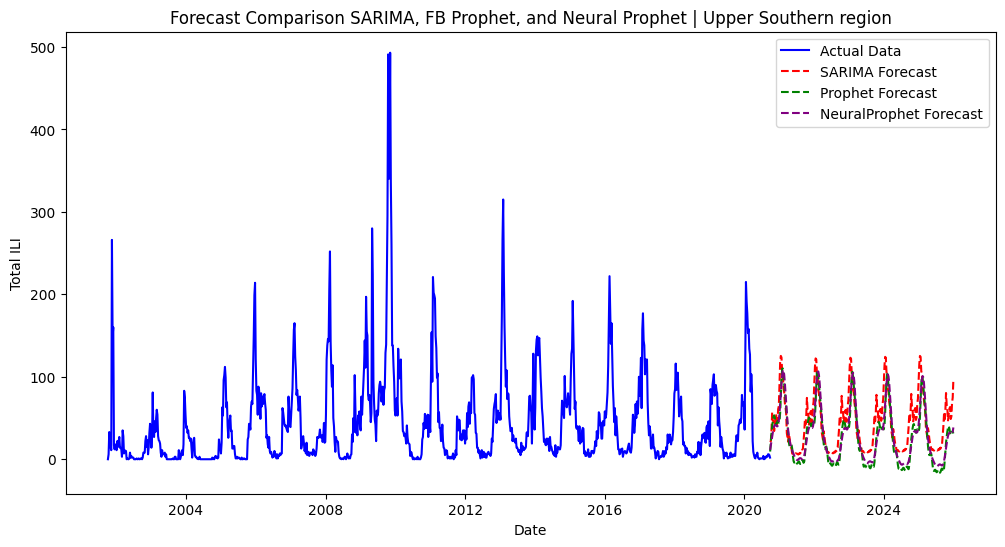

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from neuralprophet import NeuralProphet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warningsupper_southern
warnings.filterwarnings('ignore')

# Define function to calculate error metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Load the dataset
df_upper_southern = df[df['region'] == 'Upper Southern'][['weekending', 'Total_ILI']].rename(columns={'weekending': 'ds', 'Total_ILI': 'y'})
df_upper_southern['ds'] = pd.to_datetime(df_upper_southern['ds'])
df_upper_southern = df_upper_southern.sort_values('ds')

# Prepare data for SARIMA
endog = df_upper_southern['y']
sarima_model = SARIMAX(endog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_fit = sarima_model.fit(disp=False)

# Forecast for the actual period
sarima_forecast = sarima_fit.get_forecast(steps=len(df_upper_southern))
sarima_forecast_mean = sarima_forecast.predicted_mean

# Prepare data for FB Prophet
prophet_model = Prophet()
prophet_model.fit(df_upper_southern)
future_prophet = prophet_model.make_future_dataframe(periods=len(df_upper_southern), freq='W')
prophet_forecast = prophet_model.predict(future_prophet)

# Prepare data for NeuralProphet
neuralprophet_model = NeuralProphet()
neuralprophet_model.fit(df_upper_southern, freq='W')
future_neuralprophet_df = neuralprophet_model.make_future_dataframe(df_upper_southern, periods=len(df_upper_southern), n_historic_predictions=True)
neuralprophet_forecast = neuralprophet_model.predict(future_neuralprophet_df)

# Calculate error metrics for actual forecasted period (up to Dec 31, 2020)
actual_values = df_upper_southern['y'].values

# Ensure the actual values match the forecast length
sarima_forecast_aligned = sarima_forecast_mean[:len(actual_values)]
prophet_forecast_aligned = prophet_forecast['yhat'][:len(actual_values)]
neuralprophet_forecast_aligned = neuralprophet_forecast['yhat1'][:len(actual_values)]

# Calculate error metrics for SARIMA
sarima_mae, sarima_mse, sarima_rmse = calculate_metrics(actual_values, sarima_forecast_aligned)

# Calculate error metrics for FB Prophet
prophet_mae, prophet_mse, prophet_rmse = calculate_metrics(actual_values, prophet_forecast_aligned)

# Calculate error metrics for NeuralProphet
neuralprophet_mae, neuralprophet_mse, neuralprophet_rmse = calculate_metrics(actual_values, neuralprophet_forecast_aligned)

# Print error metrics
error_metrics = pd.DataFrame({
    'Model': ['SARIMA', 'FB Prophet', 'NeuralProphet'],
    'MAE': [sarima_mae, prophet_mae, neuralprophet_mae],
    'MSE': [sarima_mse, prophet_mse, neuralprophet_mse],
    'RMSE': [sarima_rmse, prophet_rmse, neuralprophet_rmse]
})

print(error_metrics)

# Plotting the forecast up to 2025-12-31
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df_upper_southern['ds'], actual_values, label='Actual Data', color='blue')

# Extend the forecasts for the future period
future_dates = pd.date_range(start=df_upper_southern['ds'].max(), end='2025-12-31', freq='W')

# Extend SARIMA forecast
sarima_future_forecast = sarima_fit.get_forecast(steps=len(future_dates)).predicted_mean
plt.plot(future_dates, sarima_future_forecast, label='SARIMA Forecast', color='red', linestyle='--')

# Correctly create future dataframe for FB Prophet
future_prophet_extended = prophet_model.make_future_dataframe(periods=len(future_dates), freq='W')
prophet_future_forecast = prophet_model.predict(future_prophet_extended)
prophet_future_forecast_aligned = prophet_future_forecast['yhat'][-len(future_dates):]
plt.plot(future_dates, prophet_future_forecast_aligned, label='Prophet Forecast', color='green', linestyle='--')

# Correctly create future dataframe for NeuralProphet
future_neuralprophet_df_extended = neuralprophet_model.make_future_dataframe(df_upper_southern, periods=len(future_dates), n_historic_predictions=False)
neuralprophet_future_forecast = neuralprophet_model.predict(future_neuralprophet_df_extended)
neuralprophet_future_forecast_aligned = neuralprophet_future_forecast['yhat1'][-len(future_dates):]
plt.plot(future_dates, neuralprophet_future_forecast_aligned, label='NeuralProphet Forecast', color='purple', linestyle='--')

plt.title('Forecast Comparison SARIMA, FB Prophet, and Neural Prophet | Upper Southern region')
plt.xlabel('Date')
plt.ylabel('Total ILI')
plt.legend()
plt.show()

In [ ]:
#           Model        MAE          MSE       RMSE
#0         SARIMA  32.276961  2427.178604  49.266404
#1     FB Prophet  22.961111  1684.226303  41.039326
#2  NeuralProphet  20.995309  1713.906969  41.399360

- Best Performing Model: FB Prophet, as it has the lowest RMSE and MSE, indicating fewer large errors and good overall accuracy.
- Close Competitor: NeuralProphet, which has the lowest MAE, indicating it has the smallest average error magnitude.
- SARIMA Performance: The SARIMA model, while capturing the general seasonal trends, has higher error metrics compared to FB Prophet and NeuralProphet, indicating it is less accurate for this dataset.

# Conclusion on Upper Southern region data
In summary, both FB Prophet and NeuralProphet models show good performance, with FB Prophet slightly outperforming NeuralProphet in terms of RMSE and MSE, while NeuralProphet has a marginally better MAE. The SARIMA model, although effective, has higher errors compared to the other two models.